In [1]:
!pip install kmodes

In [2]:
# import key libraries
import pyreadstat
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk

# other libraries
import missingno as msno
from math import ceil
from regressors import stats
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load SAS file
og_df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

In [4]:
df = og_df.copy()

# **Dataset exploration**

In [5]:
# data types
df.dtypes

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [6]:
# data description
df.describe(include = "all").T

count unique          top  freq         mean          std  \
CustID         10296.0    NaN          NaN   NaN       5148.5   2972.34352   
FirstPolYear   10266.0    NaN          NaN   NaN  1991.062634   511.267913   
BirthYear      10279.0    NaN          NaN   NaN  1968.007783    19.709476   
EducDeg          10296      5  3 - BSc/MSc  4799          NaN          NaN   
MonthSal       10260.0    NaN          NaN   NaN  2506.667057  1157.449634   
GeoLivArea     10295.0    NaN          NaN   NaN     2.709859     1.266291   
Children       10275.0    NaN          NaN   NaN     0.706764     0.455268   
CustMonVal     10296.0    NaN          NaN   NaN   177.892605  1945.811505   
ClaimsRate     10296.0    NaN          NaN   NaN     0.742772     2.916964   
PremMotor      10262.0    NaN          NaN   NaN   300.470252   211.914997   
PremHousehold  10296.0    NaN          NaN   NaN   210.431192   352.595984   
PremHealth     10253.0    NaN          NaN   NaN   171.580833   296.405976   
PremLife       10192.0    NaN          NaN   NaN    41.855782    47.480632   
PremWork       10210.0    NaN          NaN   NaN    41.277514    51.513572   

                     min      25%     50%       75%       max  
CustID               1.0  2574.75  5148.5   7722.25   10296.0  
FirstPolYear      1974.0   1980.0  1986.0    1992.0   53784.0  
BirthYear         1028.0   1953.0  1968.0    1983.0    2001.0  
EducDeg              NaN      NaN     NaN       NaN       NaN  
MonthSal           333.0   1706.0  2501.5   3290.25   55215.0  
GeoLivArea           1.0      1.0     3.0       4.0       4.0  
Children             0.0      0.0     1.0       1.0       1.0  
CustMonVal    -165680.42    -9.44  186.87  399.7775  11875.89  
ClaimsRate           0.0     0.39    0.72      0.98     256.2  
PremMotor          -4.11   190.59  298.61     408.3  11604.42  
PremHousehold      -75.0    49.45   132.8    290.05   25048.8  
PremHealth         -2.11    111.8  162.81    219.82   28272.0  
PremLife            -7.0     9.89   25.56     57.79     398.3  
PremWork           -12.0    10.67   25.67     56.79    1988.7

In [7]:
# take a look at the data
df.head(10)

CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  2 - High School    2177.0         1.0   
1     2.0        1981.0     1995.0  2 - High School     677.0         4.0   
2     3.0        1991.0     1970.0        1 - Basic    2277.0         3.0   
3     4.0        1990.0     1981.0      3 - BSc/MSc    1099.0         4.0   
4     5.0        1986.0     1973.0      3 - BSc/MSc    1763.0         4.0   
5     6.0        1986.0     1956.0  2 - High School    2566.0         4.0   
6     7.0        1979.0     1943.0  2 - High School    4103.0         4.0   
7     8.0        1988.0     1974.0  2 - High School    1743.0         4.0   
8     9.0        1981.0     1978.0      3 - BSc/MSc    1862.0         1.0   
9    10.0        1976.0     1948.0      3 - BSc/MSc    3842.0         1.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   
5       1.0      -24.33        1.00     440.75          18.90      114.80   
6       0.0      -66.01        1.05     156.92         295.60      317.95   
7       1.0     -144.91        1.13     248.27         397.30      144.36   
8       1.0      356.53        0.36     344.51          18.35      210.04   
9       0.0     -119.35        1.12     209.26         182.25      271.94   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45  
5      7.00      7.67  
6     14.67     26.34  
7     66.68     53.23  
8      8.78      9.89  
9     39.23     55.12

In [8]:
# set customer ID as index
df.CustID = df.CustID.astype("int")
df.set_index("CustID", inplace=True)

In [9]:
# check data types
df.dtypes

FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [10]:
# check for duplicated observations
print("Number of duplicate observations:", df.duplicated().sum())

# remove duplicate observations
df.drop_duplicates(inplace = True)
print("Removing duplicates...")
print("Number of duplicate observations:", df.duplicated().sum())

Number of duplicate observations: 3
Removing duplicates...
Number of duplicate observations: 0


In [11]:
# starting number of observations after duplicate removal
print(len(df))

10293


# **Cleaning up the dataset**

## Changing data types

In [12]:
# changing data types
# extract only number from EducDeg and convert to categorical
# empty strings converted to NaN
# could also use sklearn's LabelEncoder??????????
df.EducDeg = df.EducDeg.str.extract("(\d+)")
df.EducDeg = df.EducDeg.astype("category")

# convert other features to categorical
df.GeoLivArea = df.GeoLivArea.astype("category")
df.Children = df.Children.astype("category")

# check if changes were successful
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10293 entries, 1 to 10296
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FirstPolYear   10263 non-null  float64 
 1   BirthYear      10276 non-null  float64 
 2   EducDeg        10276 non-null  category
 3   MonthSal       10257 non-null  float64 
 4   GeoLivArea     10292 non-null  category
 5   Children       10272 non-null  category
 6   CustMonVal     10293 non-null  float64 
 7   ClaimsRate     10293 non-null  float64 
 8   PremMotor      10259 non-null  float64 
 9   PremHousehold  10293 non-null  float64 
 10  PremHealth     10250 non-null  float64 
 11  PremLife       10189 non-null  float64 
 12  PremWork       10207 non-null  float64 
dtypes: category(3), float64(10)
memory usage: 915.2 KB


## Cross-field validation

In [13]:
# 1997 rows where birth year is after the first policy year
df[df.BirthYear > df.FirstPolYear]

# high number of inconsistencies indicates systematic error
# assumption: people introduce the years in the wrong fields and many FirstPolYear and BirthYear are swapped
# swap FirstPolYear and BirthYear values when birth is after first policy creation
row_selector = df.BirthYear > df.FirstPolYear
df.loc[row_selector, ["FirstPolYear", "BirthYear"]] = df.loc[row_selector, ["BirthYear", "FirstPolYear"]].values

## Dealing with outliers

In [14]:
# store copy of dataframe before removing outliers
df_outliers = df.copy()

In [15]:
# define metric and non-metric features
metric_features = df.select_dtypes(include = np.number).columns.tolist()
non_metric_features = df.columns.drop(metric_features).tolist()

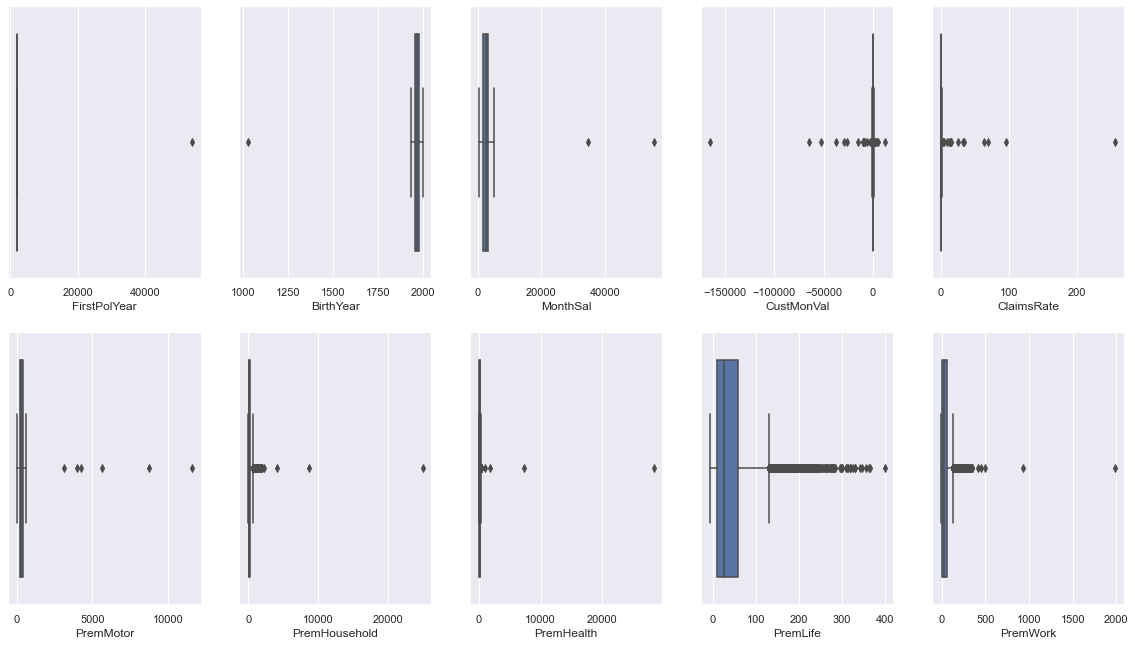

In [16]:
# boxplot of numeric variables to detect outliers
sns.set()

fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# iterate through axes objects and associate each box plot
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax)
    
plt.show()

In [17]:
# assume that 1028 in BirthYear is a typo and in reality corresponds to 1928
# 0 and 9 are fairly close in a qwerty keyboard
df.loc[df.BirthYear == 1028, "BirthYear"] = 1928

# remove outliers from main df
# should we store outliers in another df to cluster in the end????????????
df = df[~df.FirstPolYear.ge(2017)]
df = df[~df.MonthSal.ge(20000)]
df = df[~df.CustMonVal.le(-2000)]
df = df[~df.CustMonVal.ge(1500)]
df = df[~df.ClaimsRate.ge(4)]
df = df[~df.PremMotor.ge(3000)]
df = df[~df.PremHousehold.ge(1600)]
df = df[~df.PremHealth.ge(5000)]
df = df[~df.PremWork.ge(300)]

# compute number of outliers removed
n_outliers = len(df_outliers) - len(df)
perc_removed = round(n_outliers/len(df_outliers)*100, 2)
print(f"Number of outliers removed: {n_outliers} ({perc_removed}% of all observations)")

Number of outliers removed: 55 (0.53% of all observations)


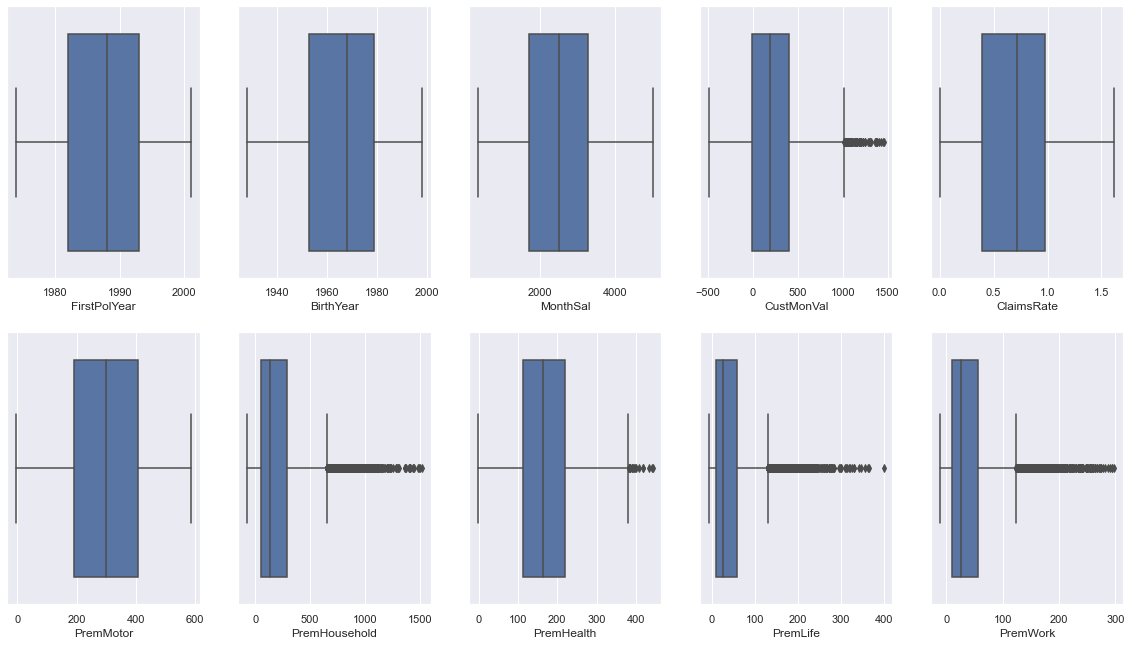

In [18]:
# boxplots of numeric variables after removing outliers
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax)
    
plt.show()

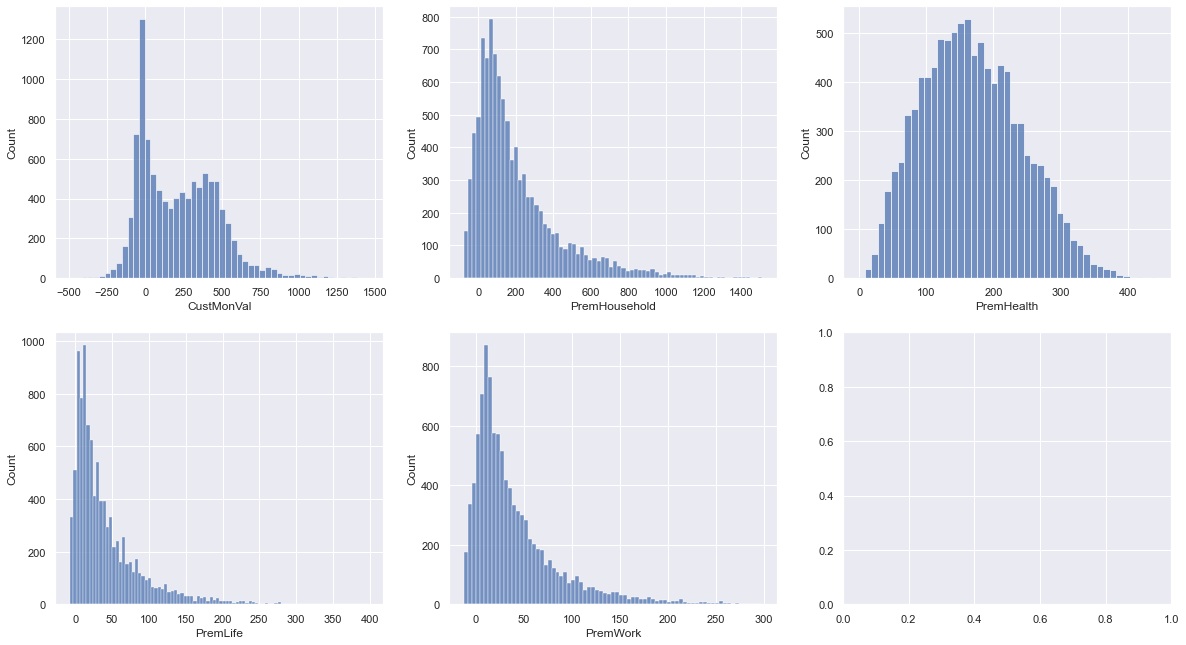

In [19]:
# CustMonVal, PremHousehold, PremHealth, PremLife, PremWork may require further processing
# histograms
skewed_metric_features = ["CustMonVal", "PremHousehold", "PremHealth", "PremLife", "PremWork"]

sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, 3, figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), skewed_metric_features):
    sns.histplot(x=df[feat], ax=ax)
    
plt.show()

In [20]:
# new look at the data after removing outliers
df.describe(include="all").T

count unique  top    freq         mean         std     min  \
FirstPolYear   10208.0    NaN  NaN     NaN  1987.629604    6.540021  1974.0   
BirthYear      10221.0    NaN  NaN     NaN   1966.42491   15.468052  1928.0   
EducDeg          10221      4    3    4782          NaN         NaN     NaN   
MonthSal       10202.0    NaN  NaN     NaN  2501.489316  982.555692   333.0   
GeoLivArea     10237.0    4.0  4.0  4120.0          NaN         NaN     NaN   
Children       10217.0    2.0  1.0  7222.0          NaN         NaN     NaN   
CustMonVal     10238.0    NaN  NaN     NaN    217.14454  254.723434  -490.2   
ClaimsRate     10238.0    NaN  NaN     NaN     0.680096    0.318477     0.0   
PremMotor      10205.0    NaN  NaN     NaN   297.623278  137.655141   -4.11   
PremHousehold  10238.0    NaN  NaN     NaN   205.072998  230.564861   -75.0   
PremHealth     10196.0    NaN  NaN     NaN   168.115505   74.095068   -2.11   
PremLife       10135.0    NaN  NaN     NaN     41.81805   47.492666    -7.0   
PremWork       10152.0    NaN  NaN     NaN     40.49038   45.289665   -12.0   

                  25%     50%       75%      max  
FirstPolYear   1982.0  1988.0    1993.0   2001.0  
BirthYear      1953.0  1968.0    1979.0   1998.0  
EducDeg           NaN     NaN       NaN      NaN  
MonthSal       1711.0  2504.0    3291.0   5021.0  
GeoLivArea        NaN     NaN       NaN      NaN  
Children          NaN     NaN       NaN      NaN  
CustMonVal    -9.1925  187.04  398.8675  1455.94  
ClaimsRate       0.39    0.72      0.98     1.62  
PremMotor      191.48  299.28     408.3   585.22  
PremHousehold   49.45   132.8     289.5  1513.05  
PremHealth     111.91  162.92    219.82   442.86  
PremLife         9.89   25.56     57.79    398.3  
PremWork        10.67   25.67     56.01    298.5

Dealing with missing values.

In [21]:
# store copy of dataframe before removing missing values
df_nan = df.copy()

In [22]:
# checking feature completeness
nan_byfeature = df.isna().sum()
nan_pc_byfeature = df.isna().mean()*100
feature_nans = pd.concat([nan_byfeature, nan_pc_byfeature], axis=1)
feature_nans.rename(columns = {0: 'nr', 1: '%'}, inplace=True)
print('Missing values per feature:\n', feature_nans)

# checking max number of missing values per row
row_nan_count = []
for row in range(len(df)):
    row_nan_count.append(df.iloc[row].isna().sum())
print('\nMax NaN per row:', np.max(row_nan_count))

# not enough missing values in a single feature to merit excluding that feature
# not enough missing values in a single row to merit excluding those observations

Missing values per feature:
                 nr         %
FirstPolYear    30  0.293026
BirthYear       17  0.166048
EducDeg         17  0.166048
MonthSal        36  0.351631
GeoLivArea       1  0.009768
Children        21  0.205118
CustMonVal       0  0.000000
ClaimsRate       0  0.000000
PremMotor       33  0.322329
PremHousehold    0  0.000000
PremHealth      42  0.410236
PremLife       103  1.006056
PremWork        86  0.840008

Max NaN per row: 4


In [23]:
# remove rows with missing FirstPolYear and missing BirthYear
# removes a total of 44 rows
df = df[~df.FirstPolYear.isna()]
df = df[~df.BirthYear.isna()]

# remove rows with missing EducDeg
# removes 2 rows (only 2 NaN remaining after removing NaNs in year columns)
df = df[~df.EducDeg.isna()]

# replace NaN in Premiums with 0
# assumes no info about Premiums means no premium is paid
df.PremMotor.fillna(0, inplace=True)
df.PremHealth.fillna(0, inplace=True)
df.PremLife.fillna(0, inplace=True)
df.PremWork.fillna(0, inplace=True)

# replace missing MonthSal values with mean salary
# df.MonthSal.fillna(df.MonthSal.mean(), inplace=True)

In [24]:
# create a linear regression model to impute missing MonthSal values

# define independent and dependent variables
X = df.dropna().drop(["MonthSal"], axis = 1)
y = df.dropna().MonthSal

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# scale train and test data
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create and fit model
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)

# predict y
y_pred = lin_model.predict(X_test_scaled)

# evaluate the predictions of the linear reg model
xlabels = X_train.columns
stats.summary(clf = lin_model, X = X_train_scaled, y = y_train, xlabels = xlabels)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
mae = mean_absolute_error(y_test, y_pred)

print(mse)
print(rmse)
print(mae)

Residuals:
       Min        1Q  Median       3Q       Max
-1540.5954 -281.5423  -8.157 272.7629 1610.7632


Coefficients:
                  Estimate  Std. Error   t value   p value
_intercept     4352.541556   80.253292   54.2351  0.000000
FirstPolYear    -67.307918   20.685248   -3.2539  0.001144
BirthYear     -3490.407999   24.530530 -142.2883  0.000000
EducDeg           8.802814   20.358514    0.4324  0.665471
GeoLivArea       -7.356633   11.054603   -0.6655  0.505764
Children        -25.919510   11.905816   -2.1770  0.029510
CustMonVal       94.623479  111.903615    0.8456  0.397815
ClaimsRate       37.246525   52.773901    0.7058  0.480351
PremMotor        32.170792   62.667635    0.5134  0.607718
PremHousehold  -308.691046   57.205481   -5.3962  0.000000
PremHealth       -9.784409   51.258697   -0.1909  0.848623
PremLife       -344.392735   66.053488   -5.2138  0.000000
PremWork       -142.850454   48.055331   -2.9726  0.002963
---
R-squared:  0.82608,    Adjusted R-squared:  0.

In [25]:
# predict MonthSal NaN values
X_test = df[df.MonthSal.isna()].drop(columns="MonthSal")
X_test_scaled = scaler.transform(X_test)
y_pred = lin_model.predict(X_test_scaled)

# impute values to MonthSal NaN
df.loc[df.MonthSal.isna(), "MonthSal"] = y_pred

In [26]:
# create a logistic regression model to impute missing Children values
# split df into data and target
data = df.dropna().drop(["Children"], axis = 1)
target = df.dropna().Children

# split data into train (70%) and test (30%) datasets
# 70% have children, 30% dont, might need stratify = target
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=5, stratify = target)

# scale features using MinMaxScaler() with parameters from X_train
scaler = MinMaxScaler().fit(X_train)
# scale the training set
X_train_scaled = scaler.transform(X_train)
# scale the test set
X_test_scaled = scaler.transform(X_test)

# create a logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

# predict y
y_pred = log_model.predict(X_test_scaled)

# evaluate the predictions of the logistic reg model
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)
f1 = round(f1_score(y_test, y_pred)*100, 2)

print("Confusion matrix:\n", conf_matrix)
print("Accuracy:", accuracy, "%")
print("Precision:", precision, "%")
print("Recall:", recall, "%")
print("F1 score:", f1, "%")

Confusion matrix:
 [[ 580  315]
 [ 168 1991]]
Accuracy: 84.18 %
Precision: 86.34 %
Recall: 92.22 %
F1 score: 89.18 %


In [27]:
# predict Children NaN values
X_test = df[df.Children.isna()].drop(columns="Children")
X_test_scaled = scaler.transform(X_test)
y_pred = log_model.predict(X_test_scaled)

# impute values to Children NaN
df.loc[df.Children.isna(), "Children"] = y_pred

In [28]:
# check if all missing values were dealt with
df.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

## Data transformation (and more cross-field validation)

In [29]:
# create an Age column (present year considered to be 2016)
curr_year = 2016
ages = curr_year - df.BirthYear
# insert ages as the 3rd feature, after BirthYear
df.insert(2, "Age", ages)

In [30]:
# plot distribution of ages
plt.figure(figsize=(10,8))
plt.title("Ages")
sns.axes_style("dark")
sns.violinplot(y=df["Age"])
plt.show()

# get some stats regarding the Age column
df.Age.describe()

count    10192.000000
mean        49.567504
std         15.464799
min         18.000000
25%         37.000000
50%         48.000000
75%         63.000000
max         88.000000
Name: Age, dtype: float64

In [31]:
# check if EducDeg makes sense according to Age
# min age is 18 so everyone can have an education up to High School
# check youngest people with a BSc/MSc
print("Minimum age associated to each Education Degree:")
print(df.groupby("EducDeg").Age.min())

# finishing a BSc (EducDeg = 3) at 20 yo is possible if starting at 17
# finishing a PhD (EducDeg = 4) at 23 yo is possible if skipping MSc and finishing PhD in 3 years (UK or outside of EU)
# no incoherences in EducDeg

Minimum age associated to each Education Degree:
EducDeg
1    18.0
2    19.0
3    20.0
4    23.0
Name: Age, dtype: float64


In [32]:
# create a Generation column based on birth year
df.loc[(df.BirthYear >= 1928) & (df.BirthYear <= 1945), "Generation"] = "Silent Generation"
df.loc[(df.BirthYear >= 1946) & (df.BirthYear <= 1964), "Generation"] = "Baby Boomer"
df.loc[(df.BirthYear >= 1965) & (df.BirthYear <= 1980), "Generation"] = "Generation X"
df.loc[(df.BirthYear >= 1981) & (df.BirthYear <= 1995), "Generation"] = "Millennial"
df.loc[(df.BirthYear >= 1996) & (df.BirthYear <= 2010), "Generation"] = "Generation Z"
df.loc[(df.BirthYear >= 2011) & (df.BirthYear <= 2025), "Generation"] = "Generation Alpha"

# convert Generation data to categorical
df.Generation = df.Generation.astype("category")

# get some stats regarding the Generation column
df.Generation.describe()

count            10192
unique               5
top       Generation X
freq              3441
Name: Generation, dtype: object

In [33]:
# count number of customers per generation
gen_count = df.groupby("Generation").size().sort_values(ascending=False)

# plot number of customers per generation
plt.figure(figsize=(10,8))
plt.title("Number of customers per generation")
sns.axes_style("dark")
sns.barplot(x = gen_count.index, y = gen_count.values, order = gen_count.index)
plt.show()

# if we replace age with generation, we should remove observations that are Generation Z

In [34]:
# create a YearSal column
# Premiums are also expressed as yearly values
# could be interesting to try YearSal as a categorical variable???
df.insert(5, "YearSal", df.MonthSal*12)

In [35]:
# create a PremTotal column
premium_cols = ["PremMotor", "PremHousehold", "PremHealth", "PremLife", "PremWork"]
df["PremTotal"] = df[premium_cols].sum(axis = 1)

# get some stats regarding the PremTotal column
print(df.PremTotal.describe())

# deal with PremTotal outliers??????????????
sns.boxplot(x = df.PremTotal)

count    10192.000000
mean       750.818412
std        190.346723
min          0.000000
25%        626.240000
50%        697.130000
75%        823.032500
max       1804.440000
Name: PremTotal, dtype: float64


<AxesSubplot:xlabel='PremTotal'>

In [36]:
# no observations where PremTotal is higher than the yearly salary
len(df[df.PremTotal > df.YearSal])

0

In [37]:
# what to do when no premiums were paid in 2016?????
# it could mean that the insurance was cancelled and they are no longer customers

# 12 observations with no Premiums paid in 2016
print(f"{len(df[df.PremTotal == 0])} customer(s) paid no Premium")
# removed these 12 observations as they likely represent past customers
df = df[~(df.PremTotal == 0)]

12 customer(s) paid no Premium


In [38]:
# create a CustYears column
# number of years a customer has been a customer
df["CustYears"] = curr_year - df.FirstPolYear

# get some stats regarding the CustYears column
df.CustYears.describe()

count    10180.000000
mean        28.368173
std          6.537370
min         15.000000
25%         23.000000
50%         28.000000
75%         34.000000
max         42.000000
Name: CustYears, dtype: float64

In [39]:
# PremHousehold, PremLife, PremWork skewed to the right
# probably need to apply a transformation? however...
# sqrt does not keep sign, maybe cube root?
# log cannot be applied without first dealing with the negative values (sum min val?)

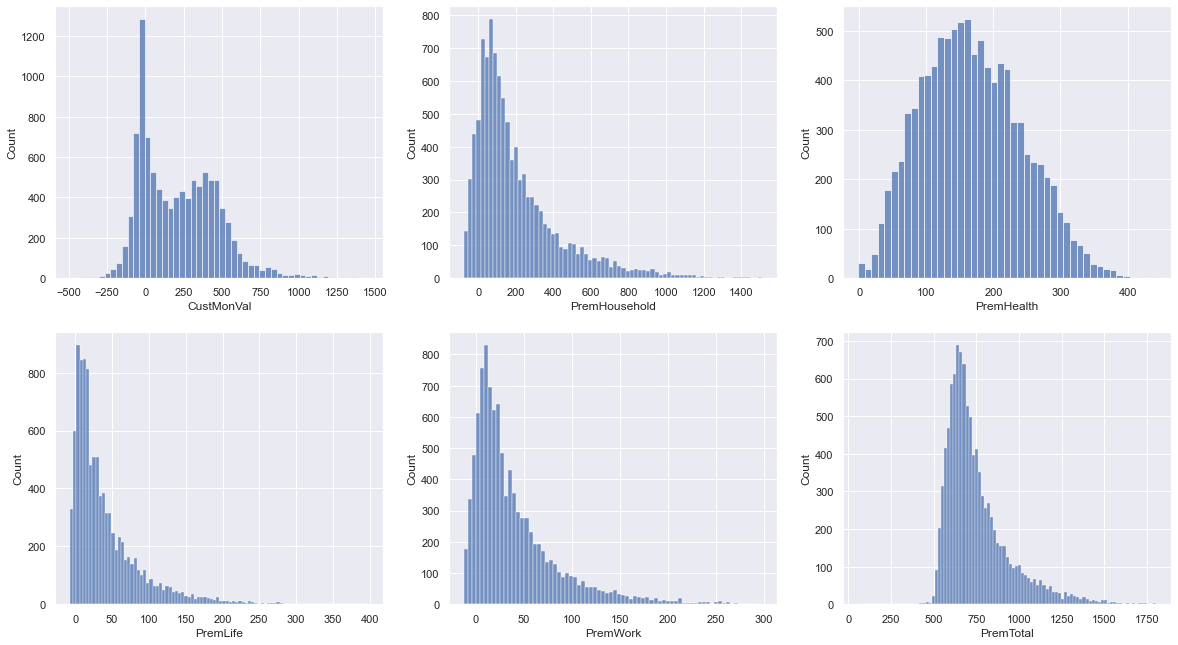

In [40]:
# CustMonVal, PremHousehold, PremHealth, PremLife, PremWork may require further processing
# histograms
skewed_metric_features = ["CustMonVal", "PremHousehold", "PremHealth", "PremLife", "PremWork", "PremTotal"]

sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, 3, figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), skewed_metric_features):
    sns.histplot(x=df[feat], ax=ax)
    
plt.show()

In [41]:
# summing the module of the minimum value to all observations
# applying transformation to normalize distributions
df.PremHousehold = np.sqrt(df.PremHousehold + 75)
df.PremHealth = np.sqrt(df.PremHealth + 2.11)
df.PremLife = np.sqrt(df.PremLife + 7)
df.PremWork = np.sqrt(df.PremWork + 12)
df.PremTotal = np.log10(df.PremTotal)

sns.set()

fig, axes = plt.subplots(2, 3, figsize=(20, 11))

for ax, feat in zip(axes.flatten(), skewed_metric_features):
    sns.histplot(x=df[feat], ax=ax)
    
plt.show()

In [42]:
# percentage of observations discarded
num_obs_discarded = len(df_outliers)-len(df)
pc_obs_discarded = round(num_obs_discarded/len(df_outliers)*100, 2)
print(f"Number of observations discarded: {num_obs_discarded} ({pc_obs_discarded} %)")

Number of observations discarded: 113 (1.1 %)


In [43]:
# new look at the dataframe
df.head()

FirstPolYear  BirthYear   Age EducDeg  MonthSal  YearSal GeoLivArea  \
CustID                                                                        
1             1985.0     1982.0  34.0       2    2177.0  26124.0        1.0   
2             1995.0     1981.0  35.0       2     677.0   8124.0        4.0   
3             1991.0     1970.0  46.0       1    2277.0  27324.0        3.0   
4             1990.0     1981.0  35.0       3    1099.0  13188.0        4.0   
5             1986.0     1973.0  43.0       3    1763.0  21156.0        4.0   

       Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                          
1           1.0      380.97        0.39     375.85      12.427791   12.184827   
2           1.0     -131.13        1.12      77.46      22.163032   10.899541   
3           0.0      504.67        0.28     206.15      17.306068   11.255665   
4           1.0      -16.99        0.99     182.48      10.878879   17.699718   
5           1.0       35.23        0.90     338.62      11.081516   13.590438   

         PremLife   PremWork    Generation  PremTotal  CustYears  
CustID                                                            
1        7.349150   5.374942    Millennial   2.823187       31.0  
2       14.194365  10.868763    Millennial   2.959499       21.0  
3        9.661780  10.536603  Generation X   2.869584       25.0  
4        6.506919   6.351378    Millennial   2.778643       26.0  
5        5.077401   7.310951  Generation X   2.798816       30.0

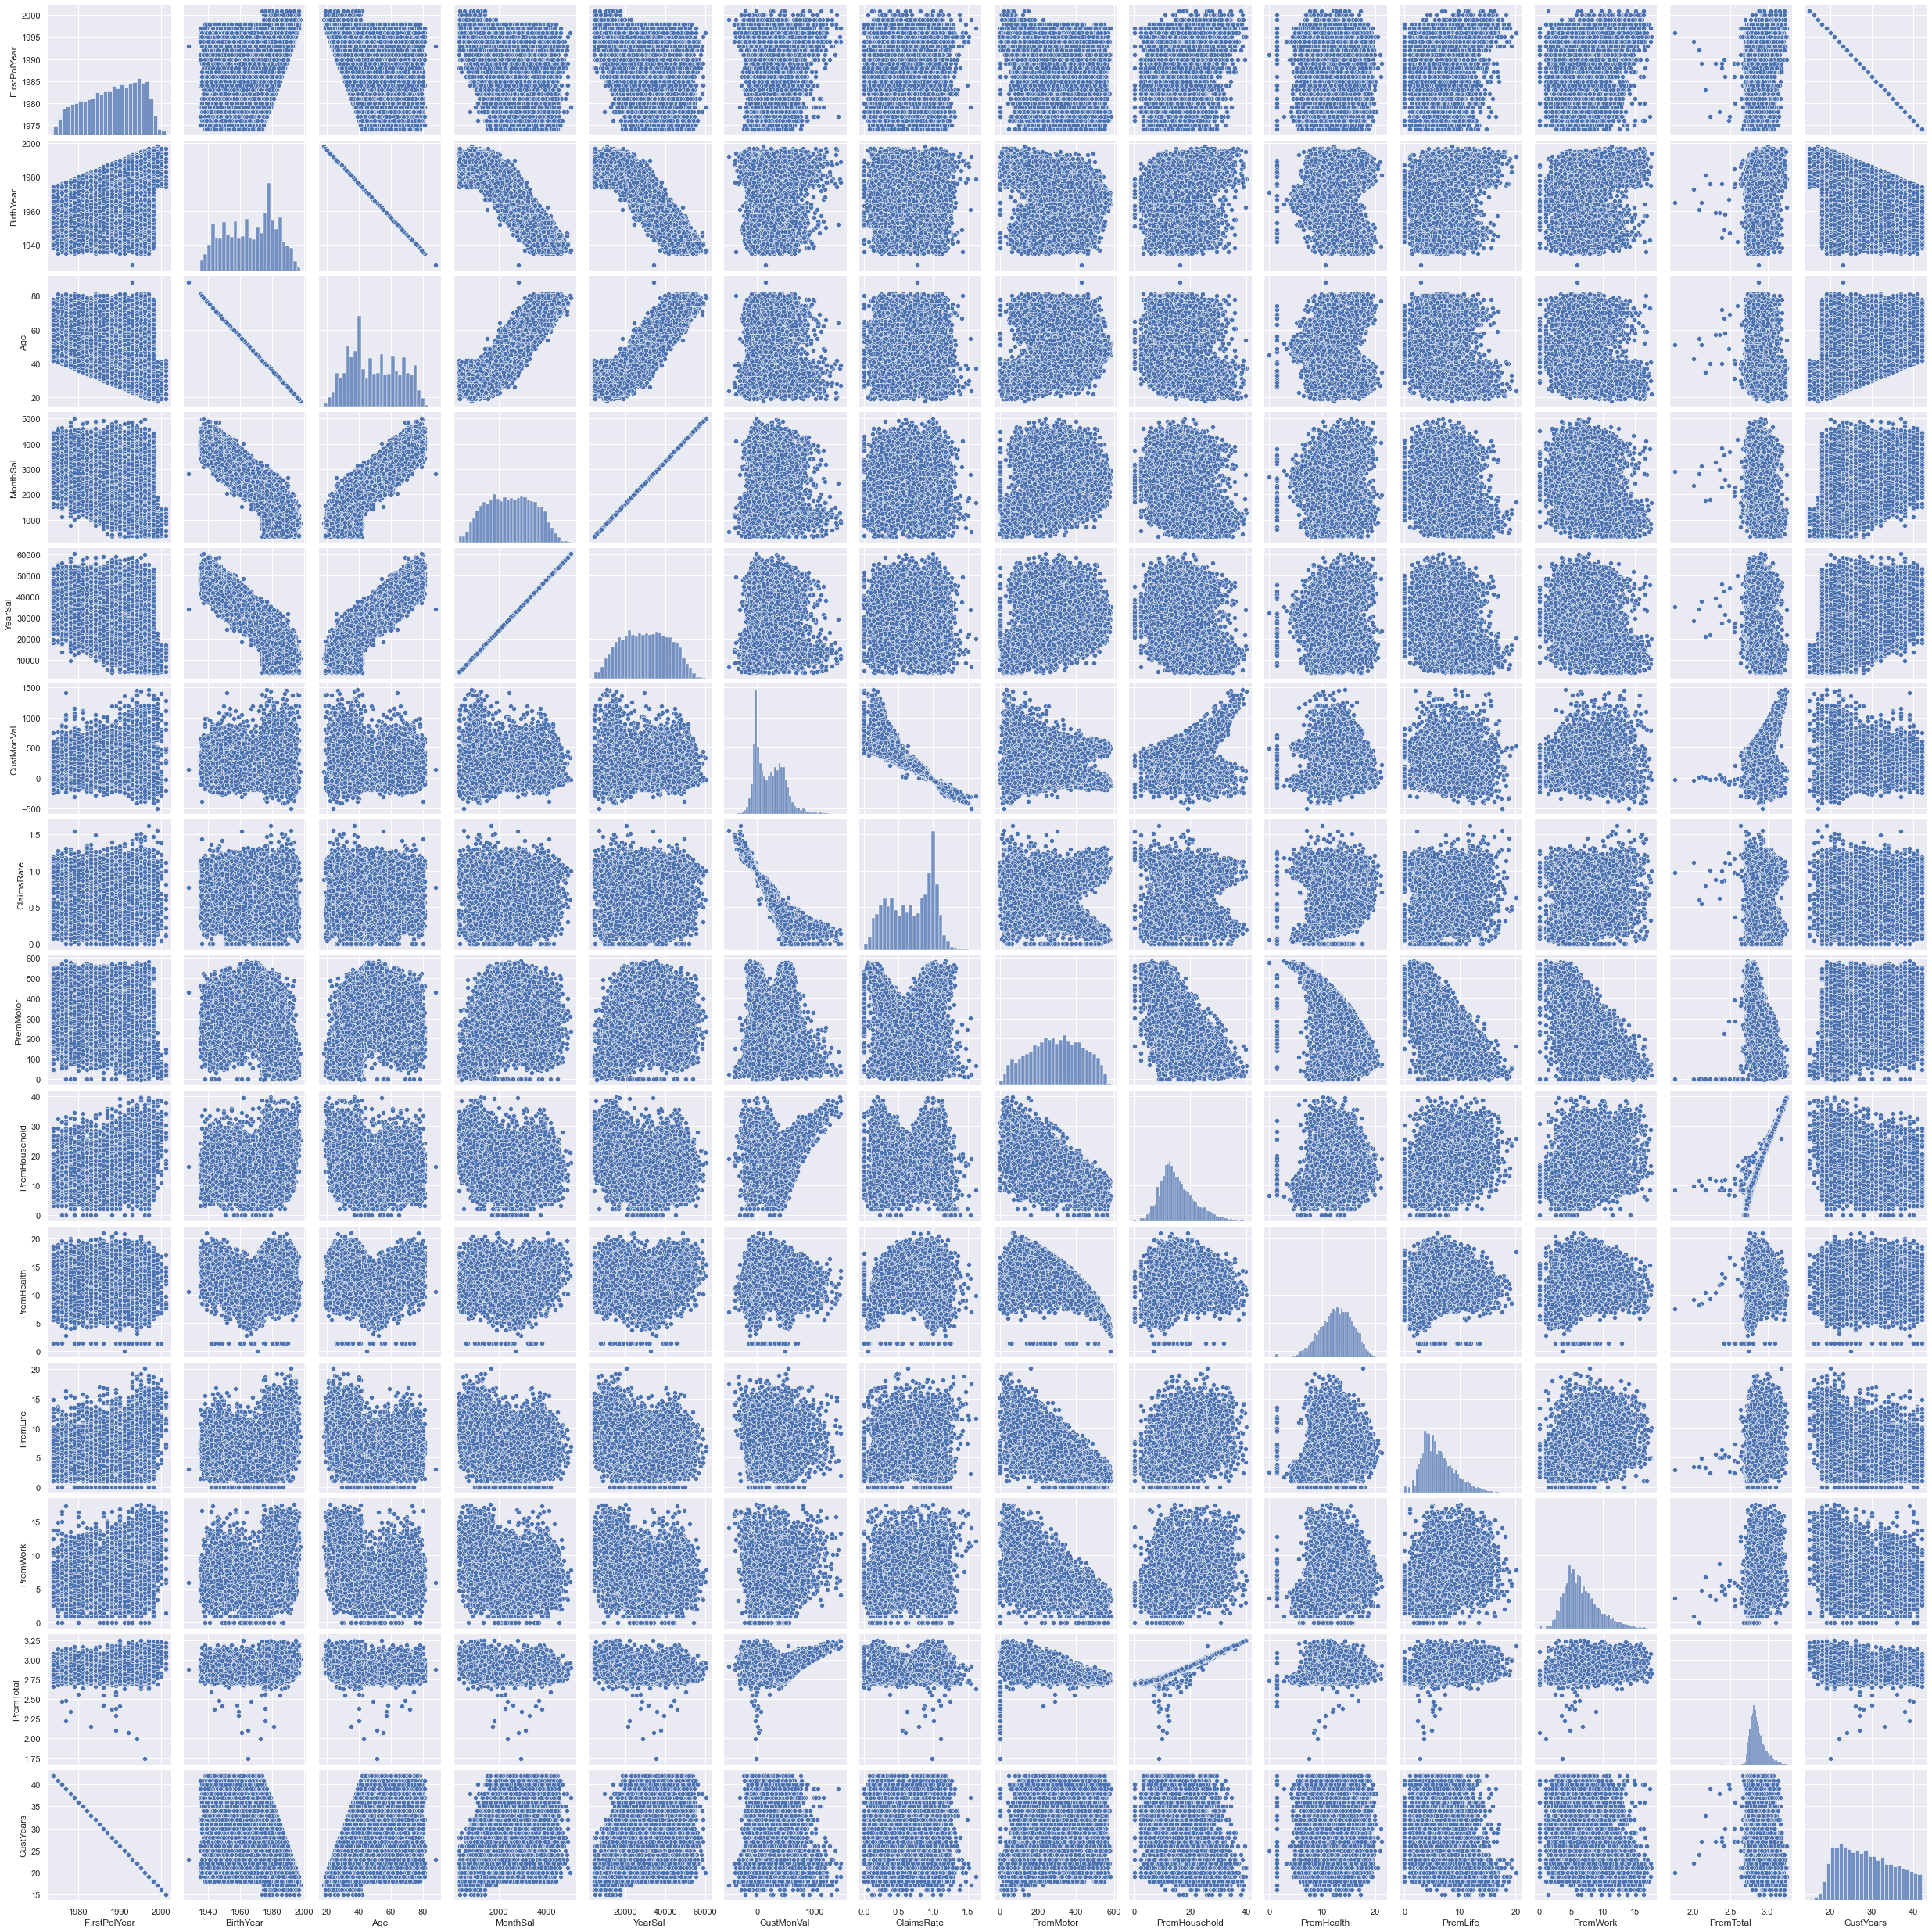

In [44]:
# bidimensional representation of metric attributes
sns.pairplot(df)

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

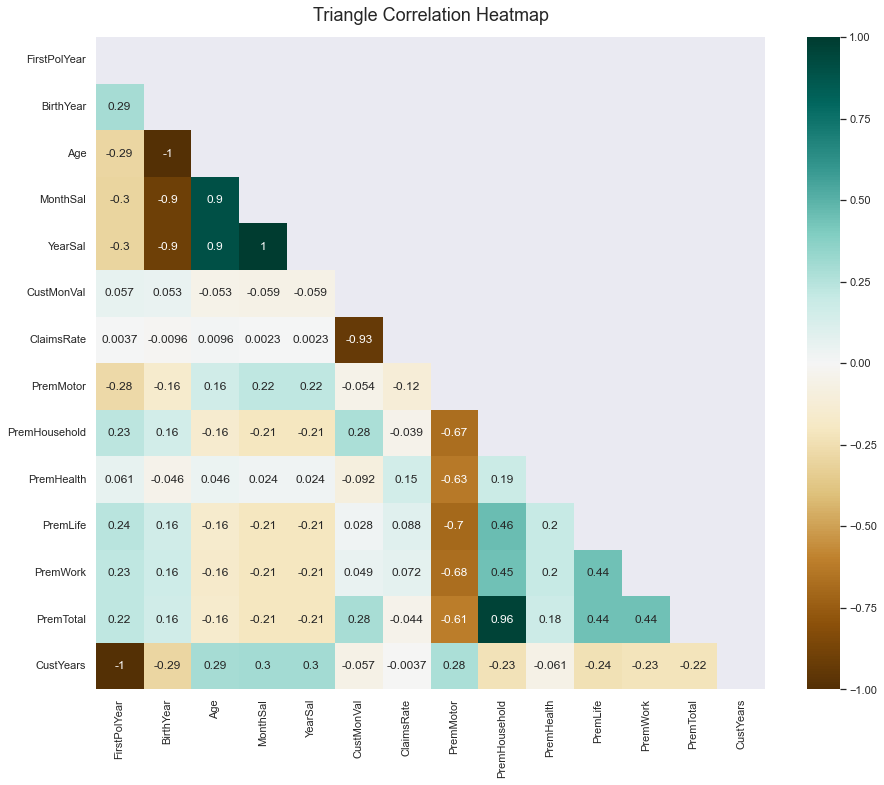

In [45]:
# create a heatmap showing correlation between all metric attributes
# pearson, spearman ????????????????
plt.subplots(figsize=(15,12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
corr_heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
corr_heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

In [46]:
# high correlations:
# FirstPoLYear redundant with CustYears, remove FirstPoLYear as the latter is more intuitive to work with
# Age redundant with BirthYear, remove BirthYear as Age is more intuitive to work with
# MonthSal redundant with YearSal, remove MonthSal as Premiums are also yearly values
# CustMonVal redundant with ClaimsRate, and ClaimsRate not correlated with anything else, remove ClaimsRate
# 
df.drop(columns = ["FirstPolYear", "BirthYear", "ClaimsRate", "MonthSal"], inplace = True)

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

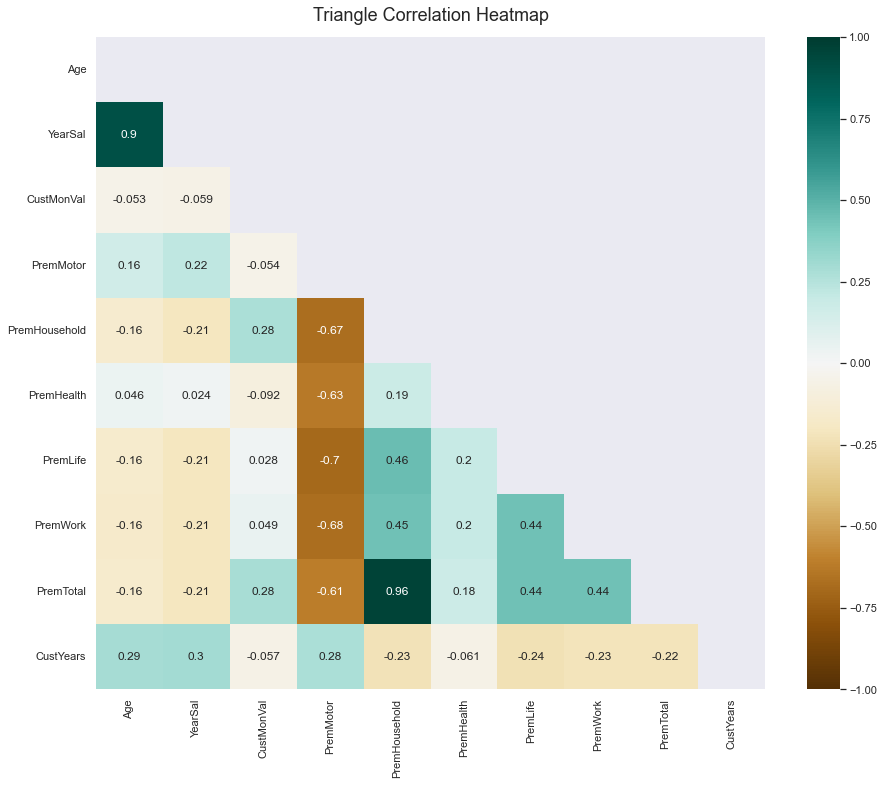

In [47]:
# create a heatmap showing correlation between the metric attributes selected
plt.subplots(figsize=(15,12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
corr_heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
corr_heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

In [48]:
# updating metric and non-metric features
metric_features = df.select_dtypes(include = np.number).columns.tolist()
non_metric_features = df.columns.drop(metric_features).tolist()

print("Metric Features:", metric_features)
print("Non-metric Features:", non_metric_features)

Metric Features: ['Age', 'YearSal', 'CustMonVal', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'PremTotal', 'CustYears']
Non-metric Features: ['EducDeg', 'GeoLivArea', 'Children', 'Generation']


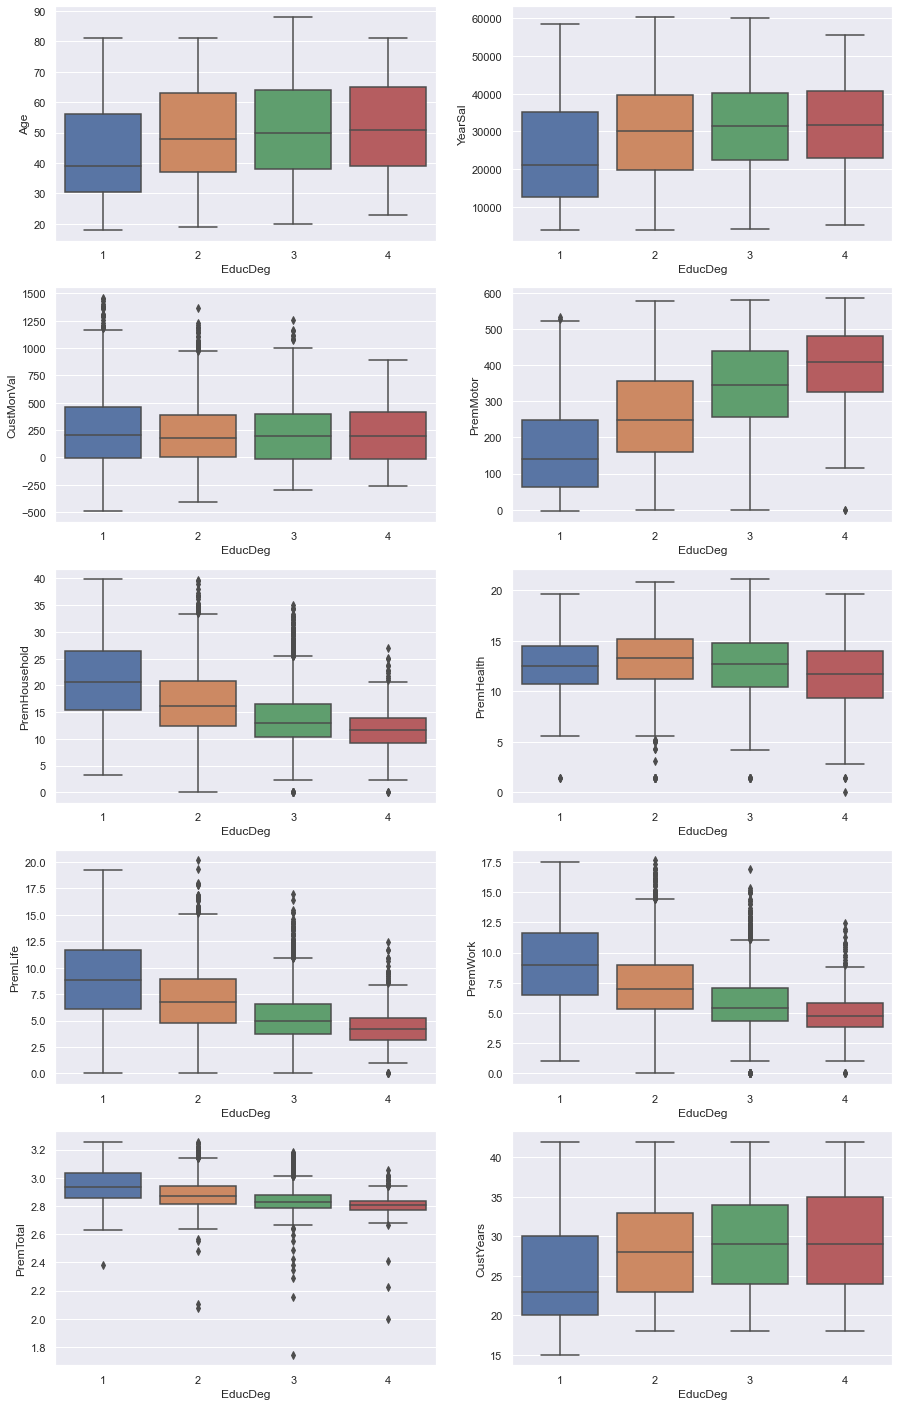

In [49]:
# explore EducDeg categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["EducDeg"], y=df[feat], ax=ax)
    
plt.show()

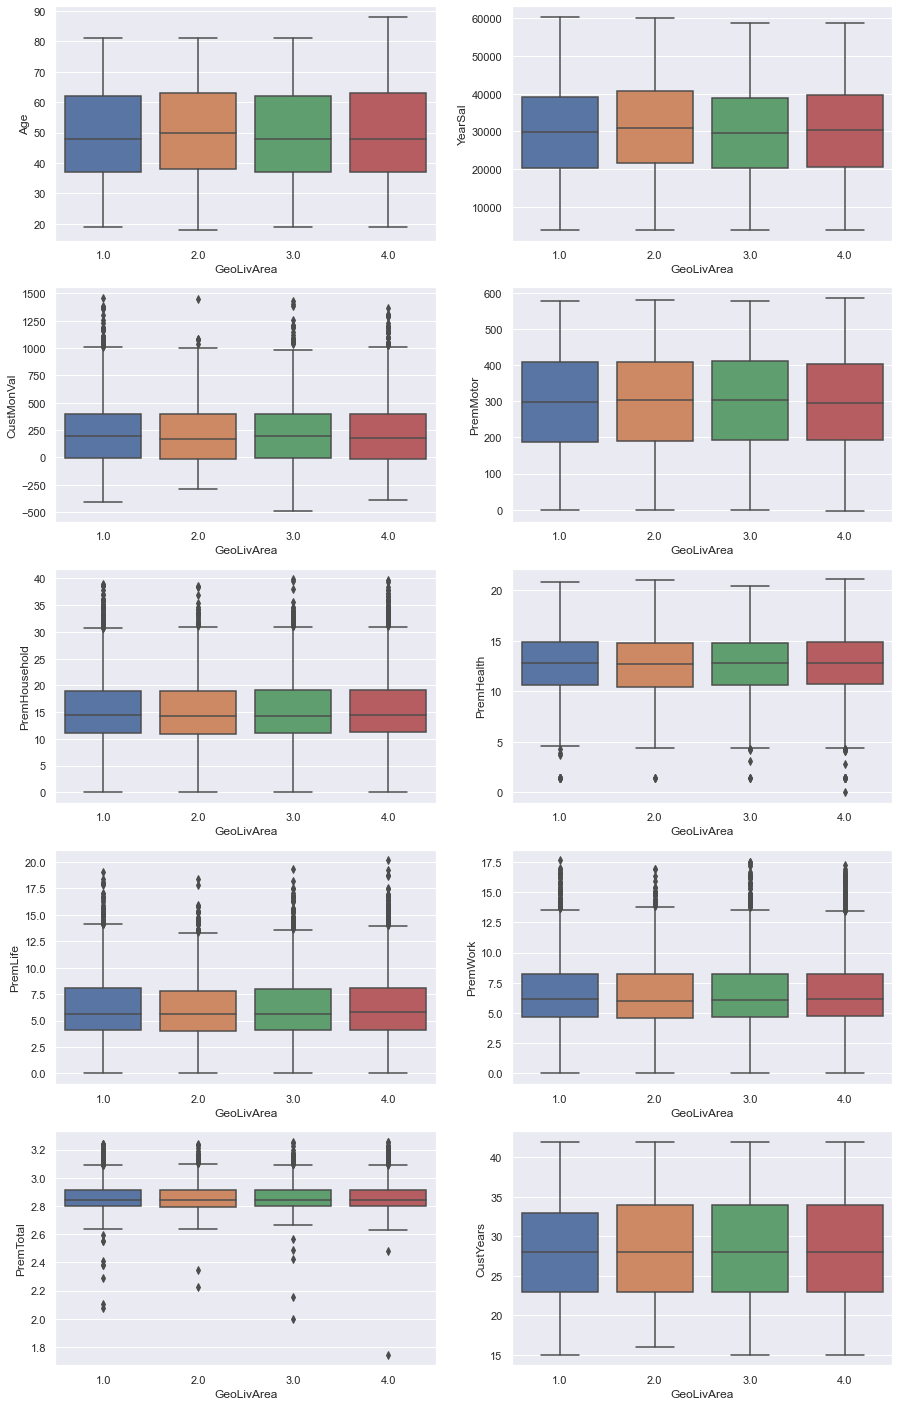

In [50]:
# we do not know much about GeoLivArea or how relevant it might be
# explore GeoLivArea categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["GeoLivArea"], y=df[feat], ax=ax)
    
plt.show()

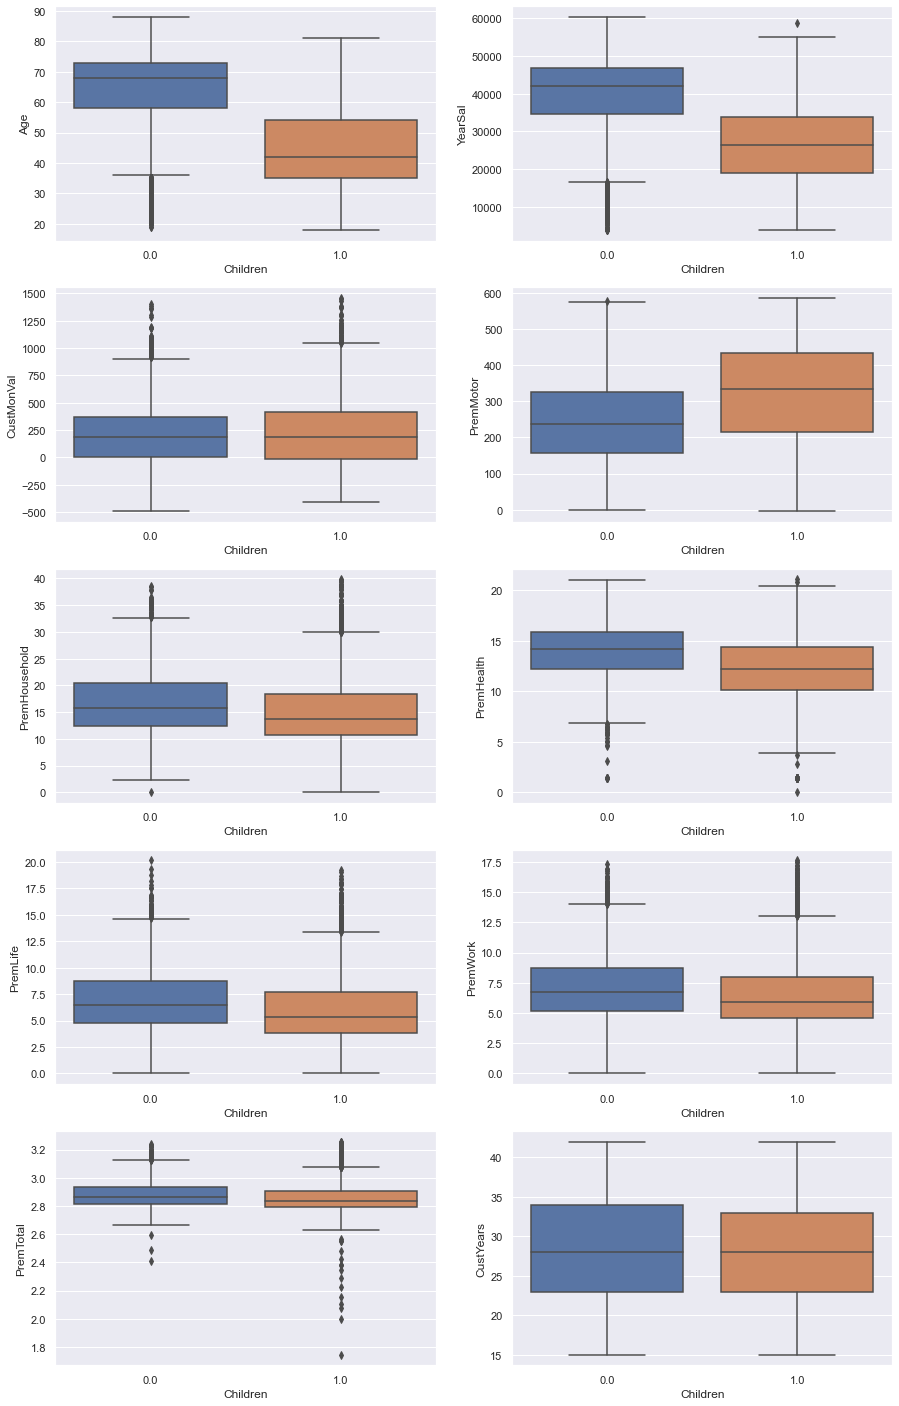

In [51]:
# explore Children categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["Children"], y=df[feat], ax=ax)
    
plt.show()

# kinda weird that median age of people with children is lower than for people without?

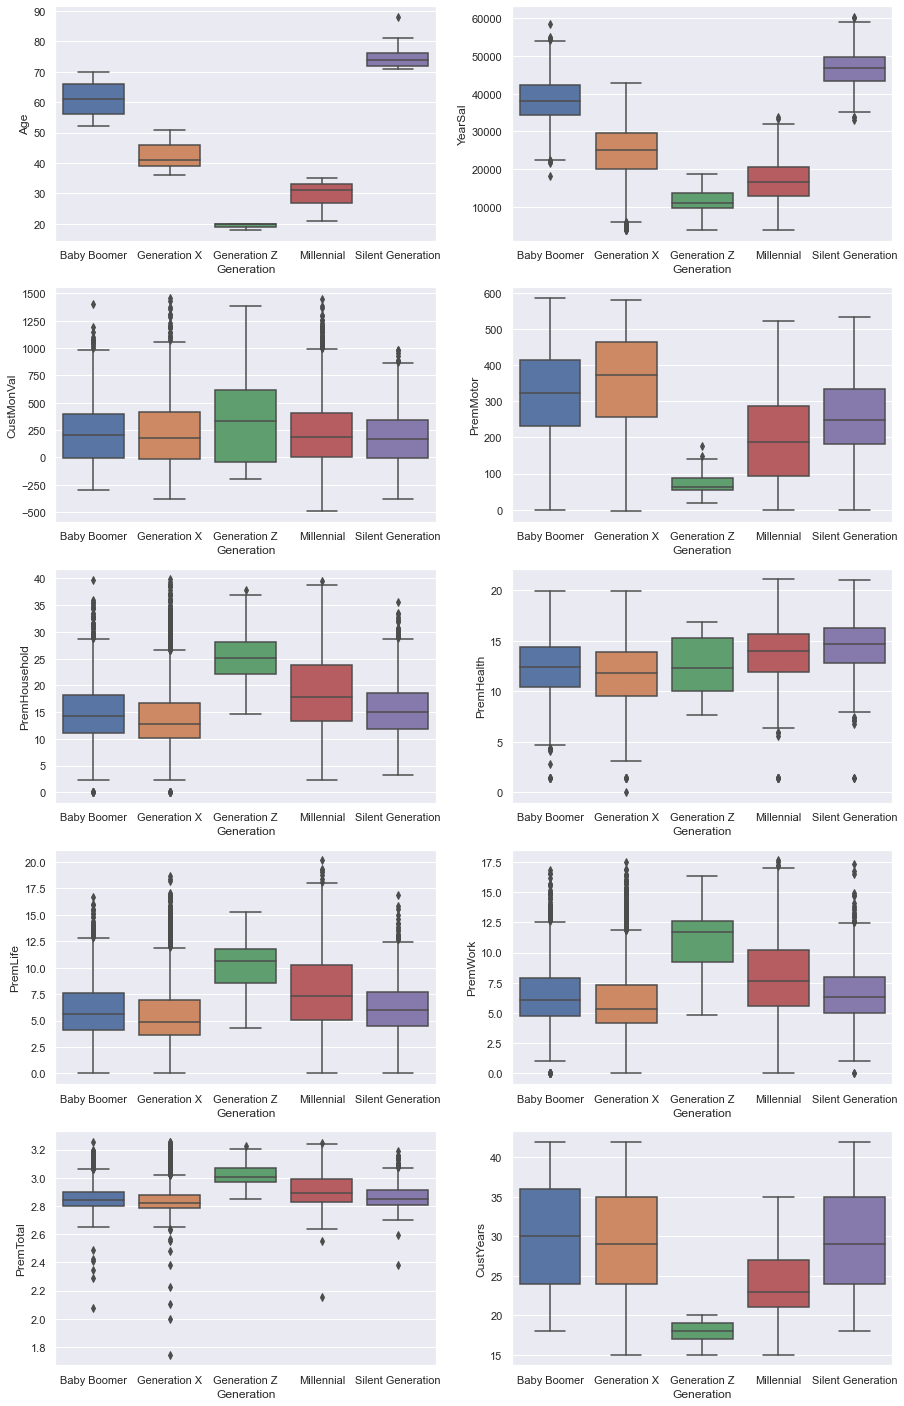

In [52]:
# explore Generation categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["Generation"], y=df[feat], ax=ax)
    
plt.show()

In [53]:
# Children and EducDeg appear to have some discriminating power
# Generation also appears to be interesting if we use age as categorical
# GeoLivArea does not seem to be particularly useful
df.drop(columns = "GeoLivArea", inplace = True)

# should we retrieve the 1 observation removed because GeoLivArea was NaN??????????

In [54]:
# reorganizing dataframe to be more intuitive
df = df.loc[:, ["Generation",
                "Age", 
                "EducDeg", 
                "Children", 
                "YearSal", 
                "CustYears", 
                "CustMonVal", 
                "PremMotor", 
                "PremHousehold", 
                "PremHealth", 
                "PremLife", 
                "PremWork", 
                "PremTotal"]]

df.head()

Generation   Age EducDeg Children  YearSal  CustYears  CustMonVal  \
CustID                                                                        
1         Millennial  34.0       2      1.0  26124.0       31.0      380.97   
2         Millennial  35.0       2      1.0   8124.0       21.0     -131.13   
3       Generation X  46.0       1      0.0  27324.0       25.0      504.67   
4         Millennial  35.0       3      1.0  13188.0       26.0      -16.99   
5       Generation X  43.0       3      1.0  21156.0       30.0       35.23   

        PremMotor  PremHousehold  PremHealth   PremLife   PremWork  PremTotal  
CustID                                                                         
1          375.85      12.427791   12.184827   7.349150   5.374942   2.823187  
2           77.46      22.163032   10.899541  14.194365  10.868763   2.959499  
3          206.15      17.306068   11.255665   9.661780  10.536603   2.869584  
4          182.48      10.878879   17.699718   6.506919   6.351378   2.778643  
5          338.62      11.081516   13.590438   5.077401   7.310951   2.798816

## Scale metric features and encode categories as binary features

In [55]:
# updating metric and non-metric features
metric_features = df.select_dtypes(include = np.number).columns.tolist()
non_metric_features = df.columns.drop(metric_features).tolist()

print("Metric Features:", metric_features)
print("Non-metric Features:", non_metric_features)

Metric Features: ['Age', 'YearSal', 'CustYears', 'CustMonVal', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'PremTotal']
Non-metric Features: ['Generation', 'EducDeg', 'Children']


In [56]:
# scale metric features and store them as df_scaled
# alternative: StandardScaler (got better results with MinMax tho)
df_scaled = df.copy()
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_scaled[metric_features])
df_scaled[metric_features] = scaled_feat
df_scaled[metric_features].describe().round(2)

Age   YearSal  CustYears  CustMonVal  PremMotor  PremHousehold  \
count  10180.00  10180.00   10180.00    10180.00   10180.00       10180.00   
mean       0.45      0.46       0.50        0.36       0.51           0.39   
std        0.22      0.21       0.24        0.13       0.23           0.16   
min        0.00      0.00       0.00        0.00       0.00           0.00   
25%        0.27      0.29       0.30        0.25       0.33           0.28   
50%        0.43      0.46       0.48        0.35       0.51           0.36   
75%        0.64      0.63       0.70        0.46       0.70           0.48   
max        1.00      1.00       1.00        1.00       1.00           1.00   

       PremHealth  PremLife  PremWork  PremTotal  
count    10180.00  10180.00  10180.00   10180.00  
mean         0.60      0.31      0.38       0.74  
std          0.14      0.15      0.16       0.07  
min          0.00      0.00      0.00       0.00  
25%          0.51      0.20      0.27       0.70  
50%          0.61      0.28      0.35       0.73  
75%          0.70      0.40      0.47       0.77  
max          1.00      1.00      1.00       1.00

In [57]:
# onehotencode categorical variables and store them as df_ohc
df_ohc = df_scaled.copy()
ohc = OneHotEncoder(sparse = False, drop = "if_binary")
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
df_ohc = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
df_ohc

x0_Baby Boomer  x0_Generation X  x0_Generation Z  x0_Millennial  \
CustID                                                                    
1                  0.0              0.0              0.0            1.0   
2                  0.0              0.0              0.0            1.0   
3                  0.0              1.0              0.0            0.0   
4                  0.0              0.0              0.0            1.0   
5                  0.0              1.0              0.0            0.0   
...                ...              ...              ...            ...   
10292              1.0              0.0              0.0            0.0   
10293              1.0              0.0              0.0            0.0   
10294              0.0              1.0              0.0            0.0   
10295              0.0              1.0              0.0            0.0   
10296              0.0              0.0              0.0            1.0   

        x0_Silent Generation  x1_1  x1_2  x1_3  x1_4  x2_1.0  
CustID                                                        
1                        0.0   0.0   1.0   0.0   0.0     1.0  
2                        0.0   0.0   1.0   0.0   0.0     1.0  
3                        0.0   1.0   0.0   0.0   0.0     0.0  
4                        0.0   0.0   0.0   1.0   0.0     1.0  
5                        0.0   0.0   0.0   1.0   0.0     1.0  
...                      ...   ...   ...   ...   ...     ...  
10292                    0.0   0.0   0.0   0.0   1.0     0.0  
10293                    0.0   1.0   0.0   0.0   0.0     0.0  
10294                    0.0   0.0   0.0   1.0   0.0     1.0  
10295                    0.0   1.0   0.0   0.0   0.0     1.0  
10296                    0.0   0.0   0.0   0.0   1.0     1.0  

[10180 rows x 10 columns]

Clustering

In [58]:
# df with the original data
# should change it to pre-transformation dataframe
df.head()

Generation   Age EducDeg Children  YearSal  CustYears  CustMonVal  \
CustID                                                                        
1         Millennial  34.0       2      1.0  26124.0       31.0      380.97   
2         Millennial  35.0       2      1.0   8124.0       21.0     -131.13   
3       Generation X  46.0       1      0.0  27324.0       25.0      504.67   
4         Millennial  35.0       3      1.0  13188.0       26.0      -16.99   
5       Generation X  43.0       3      1.0  21156.0       30.0       35.23   

        PremMotor  PremHousehold  PremHealth   PremLife   PremWork  PremTotal  
CustID                                                                         
1          375.85      12.427791   12.184827   7.349150   5.374942   2.823187  
2           77.46      22.163032   10.899541  14.194365  10.868763   2.959499  
3          206.15      17.306068   11.255665   9.661780  10.536603   2.869584  
4          182.48      10.878879   17.699718   6.506919   6.351378   2.778643  
5          338.62      11.081516   13.590438   5.077401   7.310951   2.798816

In [59]:
# df with scaled metric features and onehotencoded categorical features
df_clusters = pd.concat([df_scaled.drop(columns=non_metric_features), df_ohc], axis=1)

# renaming columns of cat features after one hot encoder
new_names = {"x0_Baby Boomer": "BabyBoomer",
             "x0_Generation X": "GenX",
             "x0_Generation Z": "GenZ",
             "x0_Millennial": "Millennial",
             "x0_Silent Generation": "SilentGen",
             "x1_1": "Basic",
             "x1_2": "HighSchool",
             "x1_3": "BSc/MSc",
             "x1_4": "PhD",
             "x2_1.0": "Children"}
df_clusters.rename(mapper=new_names, axis=1, inplace=True)

df_clusters.head()

Age   YearSal  CustYears  CustMonVal  PremMotor  PremHousehold  \
CustID                                                                        
1       0.228571  0.393345   0.592593    0.447640   0.644732       0.311862   
2       0.242857  0.073379   0.222222    0.184504   0.138411       0.556157   
3       0.400000  0.414676   0.370370    0.511202   0.356778       0.434276   
4       0.242857  0.163396   0.407407    0.243153   0.316614       0.272993   
5       0.357143  0.305034   0.555556    0.269986   0.581559       0.278078   

        PremHealth  PremLife  PremWork  PremTotal  BabyBoomer  GenX  GenZ  \
CustID                                                                      
1         0.577636  0.365047  0.305030   0.713427         0.0   0.0   0.0   
2         0.516705  0.705063  0.616807   0.803610         0.0   0.0   0.0   
3         0.533588  0.479920  0.597957   0.744123         0.0   1.0   0.0   
4         0.839075  0.323212  0.360443   0.683957         0.0   0.0   0.0   
5         0.644270  0.252205  0.414900   0.697304         0.0   1.0   0.0   

        Millennial  SilentGen  Basic  HighSchool  BSc/MSc  PhD  Children  
CustID                                                                    
1              1.0        0.0    0.0         1.0      0.0  0.0       1.0  
2              1.0        0.0    0.0         1.0      0.0  0.0       1.0  
3              0.0        0.0    1.0         0.0      0.0  0.0       0.0  
4              1.0        0.0    0.0         0.0      1.0  0.0       1.0  
5              0.0        0.0    0.0         0.0      1.0  0.0       1.0

In [60]:
# sociodemographic market segmentation
# potentially relevant features: Age/Generation, YearSal, EducDeg, Children
# some categorical, some metric
df_sociodemography = df_clusters[["Age",
                                  "YearSal",
                                  "Basic",
                                  "HighSchool",
                                  "BSc/MSc",
                                  "PhD",
                                  "Children"]
                                ]

df_sociodemography.head()

Age   YearSal  Basic  HighSchool  BSc/MSc  PhD  Children
CustID                                                               
1       0.228571  0.393345    0.0         1.0      0.0  0.0       1.0
2       0.242857  0.073379    0.0         1.0      0.0  0.0       1.0
3       0.400000  0.414676    1.0         0.0      0.0  0.0       0.0
4       0.242857  0.163396    0.0         0.0      1.0  0.0       1.0
5       0.357143  0.305034    0.0         0.0      1.0  0.0       1.0

In [77]:
# trying KMeans to determine sociodemographic clusters
# alternative: skip OneHotEncoder and use KPrototypes
# relevant paper: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.134.83&rep=rep1&type=pdf
n_clusters = np.arange(2, 11)
n_inertia = []
n_silhouette_scores = []
n_dbi_scores = []

for n in n_clusters:
    kmeans = KMeans(n_clusters = n, random_state = 0).fit(df_sociodemography)
    n_inertia.append(kmeans.inertia_)
    n_silhouette_scores.append(silhouette_score(df_sociodemography, kmeans.labels_))
    n_dbi_scores.append(davies_bouldin_score(df_sociodemography, kmeans.labels_))

<AxesSubplot:>

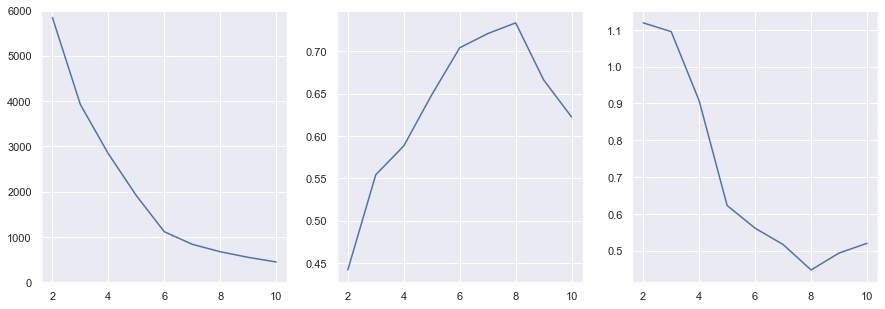

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# elbow plot - suggests 6 clusters
sns.lineplot(x = n_clusters, y = n_inertia, ax=ax[0])
ax[0].set_ylim([0, 6000])

# silhouette plot - suggests 6-8 clusters
sns.lineplot(x = n_clusters, y = n_silhouette_scores, ax=ax[1])

# dbi plot - suggests 8 clusters
sns.lineplot(x = n_clusters, y = n_dbi_scores, ax=ax[2])

In [63]:
kmeans = KMeans (n_clusters = 6, random_state = 0).fit(df_sociodemography)

<AxesSubplot:>

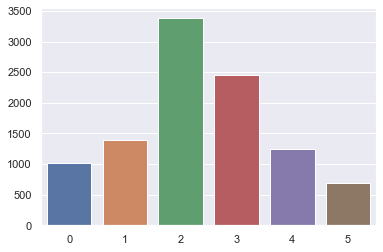

In [64]:
labels = pd.Series(kmeans.labels_).value_counts()

dist = labels.values

sns.barplot(x=labels.index, y=dist)

In [65]:
# new attempt but using KPrototypes instead of KMeans
# no OneHotEncoder
#categoricals = df[["EducDeg", "Children"]]
#metric = df_clusters[["Age", "YearSal"]]
#df_sociodemography_2 = pd.concat([categoricals, metric], axis = 1)

#n_clusters = np.arange(2, 11)
#n_silhouette_scores = []
#n_dbi_scores = []

#for n in n_clusters:
#    kproto_labels = KPrototypes(n_clusters = n, init = "Huang").fit_predict(df_sociodemography_2, categorical = [0, 1])
#    n_silhouette_scores.append(silhouette_score(df_sociodemography_2, kproto_labels))
#    n_dbi_scores.append(davies_bouldin_score(df_sociodemography_2, kproto_labels))

In [66]:
# new attempt, KMeans but using generation and not age
df_sociodemography_3 = df_clusters[["BabyBoomer",
                                  "GenX",
                                  "GenZ",
                                  "Millennial",
                                  "SilentGen",
                                  "YearSal",
                                  "Basic",
                                  "HighSchool",
                                  "BSc/MSc",
                                  "PhD",
                                  "Children"]
                                ]

n_clusters = np.arange(2, 51)
n_inertia = []
n_silhouette_scores = []
n_dbi_scores = []

for n in n_clusters:
    kmeans = KMeans(n_clusters = n, random_state = 0).fit(df_sociodemography_3)
    n_inertia.append(kmeans.inertia_)
    n_silhouette_scores.append(silhouette_score(df_sociodemography_3, kmeans.labels_))
    n_dbi_scores.append(davies_bouldin_score(df_sociodemography_3, kmeans.labels_))

<AxesSubplot:>

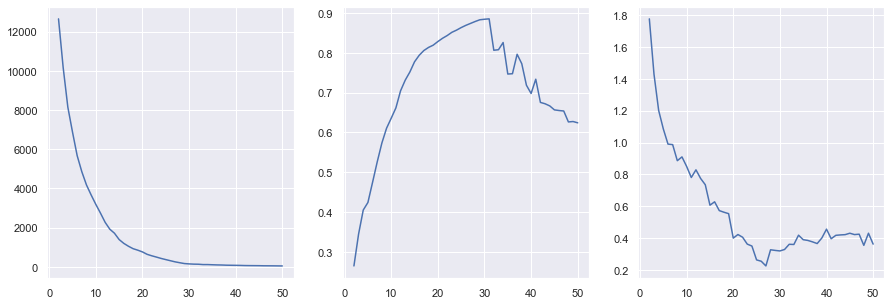

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# elbow plot - suggests 6 clusters
sns.lineplot(x = n_clusters, y = n_inertia, ax=ax[0])

# silhouette plot - suggests 6-8 clusters
sns.lineplot(x = n_clusters, y = n_silhouette_scores, ax=ax[1])

# dbi plot - suggests 8 clusters
sns.lineplot(x = n_clusters, y = n_dbi_scores, ax=ax[2])

In [82]:
kmeans = KMeans(n_clusters = 6, random_state = 0).fit(df_sociodemography)
labels = kmeans.labels_

df_clusters["labels"] = labels
df_sociodemography["labels"] = labels

In [83]:
sns.pairplot(df_sociodemography, hue="labels")